In [102]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf 
from datetime import date

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Reproducibility
SEED = 42
np.random.seed(SEED)

In [103]:
from datetime import date

symbol = "AAPL"                           # Stock ticker
start = "2016-01-01"
end = date.today().strftime("%Y-%m-%d")   # today's date in YYYY-MM-DD format

# Predict the next-day return
TARGET = "Target_Return_1d"

# Define test period (time-based split)
test_start_date = "2024-01-01"


In [104]:
df = yf.download(symbol, start=start, end=end)
df.index.name = "Date"  # ensure a clean datetime index

df.head()


/var/folders/n8/k6s3cgwn5gv4p4x929qsxlkc0000gn/T/ipykernel_16194/1416540064.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2016-01-04,23.753157,23.757667,22.997836,23.135372,270597600
2016-01-05,23.157911,23.865884,23.090272,23.843337,223164000
2016-01-06,22.704723,23.081258,22.517585,22.673158,273829600
2016-01-07,21.746477,22.576203,21.741969,22.249274,324377600
2016-01-08,21.861467,22.346226,21.816374,22.219964,283192000


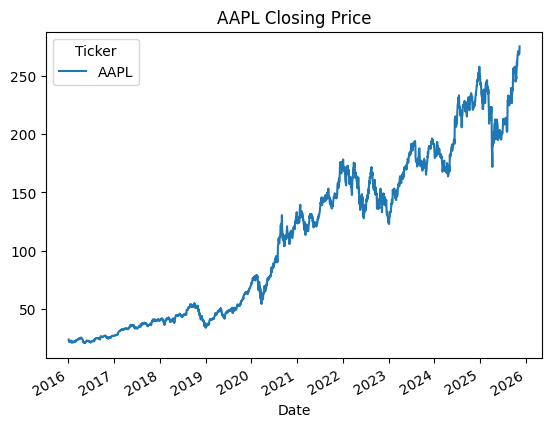

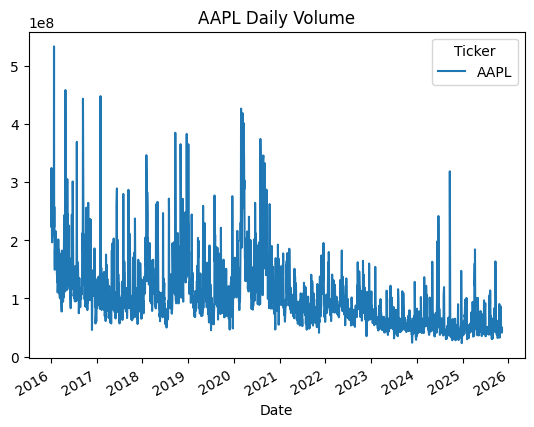

In [105]:
# ---------- 4) EDA: PRICE & VOLUME ----------
# Close over time
df["Close"].plot(title=f"{symbol} Closing Price")
plt.show()

# Volume over time
df["Volume"].plot(title=f"{symbol} Daily Volume")
plt.show()


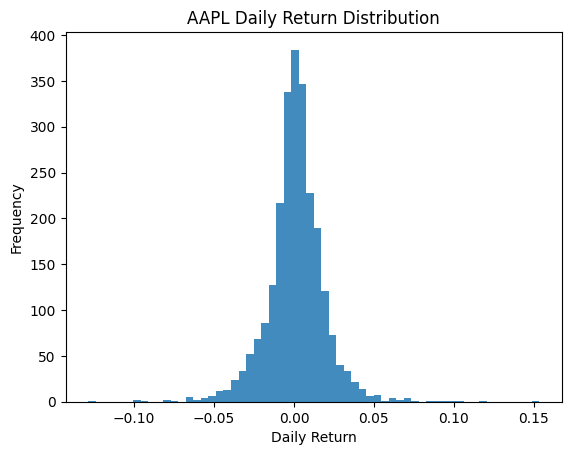

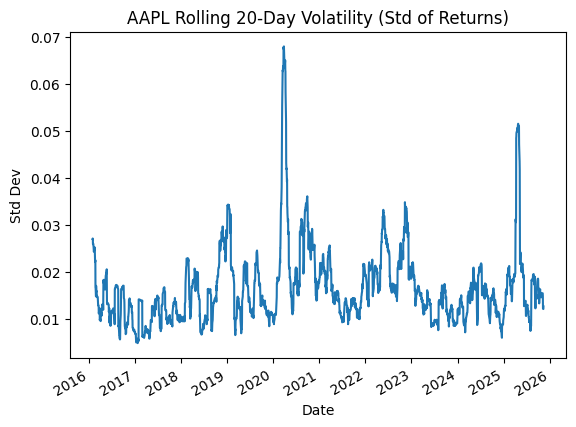

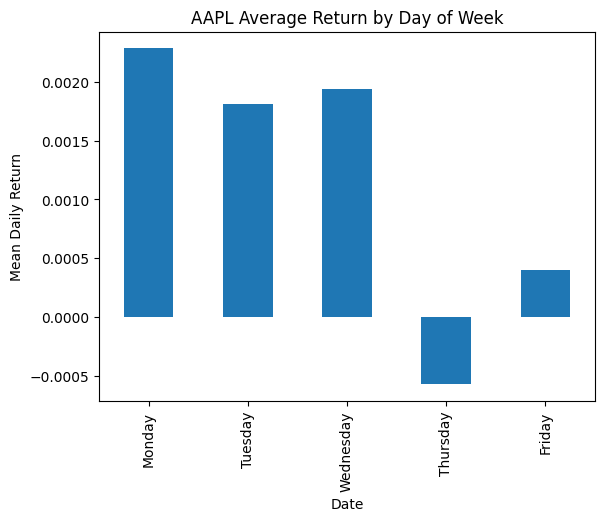

In [106]:
# --- Make sure columns are flat (handles yfinance-style MultiIndex) ---
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]

# --- Returns as a proper Series ---
ret = df["Close"].pct_change().dropna()    # 1D Series indexed by Date

# --- Distribution of daily returns ---
ret.plot(kind="hist", bins=60, alpha=0.85, title=f"{symbol} Daily Return Distribution")
plt.xlabel("Daily Return")
plt.show()

# --- Rolling 20-day volatility ---
ret.rolling(20).std().plot(title=f"{symbol} Rolling 20-Day Volatility (Std of Returns)")
plt.ylabel("Std Dev")
plt.show()

# --- Day-of-week behavior ---
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
ret.groupby(ret.index.day_name()).mean().reindex(dow_order).plot(
    kind="bar", title=f"{symbol} Average Return by Day of Week"
)
plt.ylabel("Mean Daily Return")
plt.show()


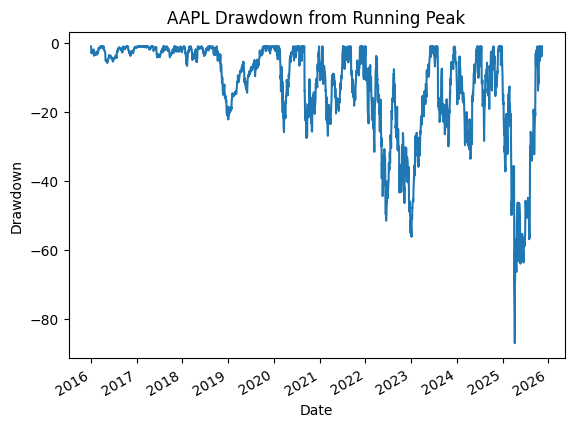

Max Drawdown: -8702.14%


In [107]:
close = df["Close"].copy()
running_peak = close.cummax()
drawdown = (close - running_peak) - 1.0

drawdown.plot(title=f"{symbol} Drawdown from Running Peak")
plt.ylabel("Drawdown")
plt.show()

print(f"Max Drawdown: {drawdown.min():.2%}")

In [108]:
def compute_rsi(close: pd.Series, window=14):
    """  
    Wilder's RSI Heuristic zones: >70 = overbought, <30 = oversold
    """
    delta = close.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(window).mean()
    roll_down = down.rolling(window).mean()
    rs = roll_up / (roll_down + 1e-9)
    return 100 - (100 / (1 + rs))

def compute_macd(close: pd.Series, fast=12, slow=26, signal=9):
    """
    MACD = EMA(fast) - EMA(slow); plus signal line and histogram.
    """
    ema_fast = close.ewm(span=fast, adjust=False).mean()
    ema_slow = close.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

In [109]:
# ---------- 8) FEATURE ENGINEERING (using Close) ----------
df_feat = df.copy()

# Basic returns based on Close
df_feat["Return_1d"] = df_feat["Close"].pct_change()
df_feat["LogReturn_1d"] = np.log1p(df_feat["Return_1d"])

# Rolling means & rolling volatility (past-only windows)
df_feat["MA_5"]   = df_feat["Close"].rolling(5).mean()
df_feat["MA_10"]  = df_feat["Close"].rolling(10).mean()
df_feat["MA_20"]  = df_feat["Close"].rolling(20).mean()
df_feat["Vol_10"] = df_feat["Return_1d"].rolling(10).std()
df_feat["Vol_20"] = df_feat["Return_1d"].rolling(20).std()

# Momentum indicators computed on Close
df_feat["RSI_14"] = compute_rsi(df_feat["Close"], 14)
macd, macd_sig, macd_hist = compute_macd(df_feat["Close"])
df_feat["MACD"] = macd
df_feat["MACD_Signal"] = macd_sig
df_feat["MACD_Hist"] = macd_hist

# Lagged returns to avoid look-ahead leakage
for k in [1,2,3,5,10]:
    df_feat[f"Return_1d_lag{k}"] = df_feat["Return_1d"].shift(k)

# Target = NEXT-DAY return (shift backward)
TARGET = "Target_Return_1d"
df_feat[TARGET] = df_feat["Return_1d"].shift(-1)

# Drop NaNs introduced by rolling/shift
df_feat = df_feat.dropna()

df_feat.head()


,Close,High,Low,Open,Volume,Return_1d,LogReturn_1d,MA_5,MA_10,MA_20,...,RSI_14,MACD,MACD_Signal,MACD_Hist,Return_1d_lag1,Return_1d_lag2,Return_1d_lag3,Return_1d_lag5,Return_1d_lag10,Target_Return_1d
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-02,21.302303,21.654034,21.257209,21.514243,149428800,-0.020222,-0.020429,21.453820,21.863722,22.047592,...,40.609996,-0.445938,-0.420882,-0.025056,-0.009349,0.034542,0.007172,0.005531,-0.004839,0.019792
2016-02-03,21.723928,21.834408,21.212115,21.419546,183857200,0.019792,0.019599,21.585944,21.853801,21.975893,...,48.174147,-0.424698,-0.421645,-0.003053,-0.020222,-0.009349,0.034542,-0.065706,0.001345,0.008035
2016-02-04,21.898483,22.063969,21.578848,21.730731,185886800,0.008035,0.008003,21.722766,21.872384,21.935581,...,45.583592,-0.389293,-0.415175,0.025882,0.019792,-0.020222,-0.009349,0.007172,-0.005063,-0.026708
2016-02-05,21.313622,21.971030,21.238814,21.880353,185672400,-0.026708,-0.027071,21.596062,21.717040,21.913938,...,45.243403,-0.403773,-0.412895,0.009122,0.008035,0.019792,-0.020222,0.034542,0.053168,0.010529
2016-02-08,21.538042,21.694459,21.091458,21.111859,216085600,0.010529,0.010474,21.555276,21.628781,21.897767,...,47.963531,-0.392614,-0.408838,0.016225,-0.026708,0.008035,0.019792,-0.009349,-0.019523,-0.000210


In [110]:
# ---------- 8) FEATURE ENGINEERING (Close-only, leak-safe, self-contained) ----------
import numpy as np
import pandas as pd

df_feat = df.copy()

# --- 0) Make sure columns are flat so "Close" works (yfinance often returns MultiIndex) ---
if isinstance(df_feat.columns, pd.MultiIndex):
    df_feat.columns = [c[0] if isinstance(c, tuple) else c for c in df_feat.columns]

# --- 1) Helper indicators (Close-only implementations) ---
def rsi(series: pd.Series, period: int = 14) -> pd.Series:
    """
    Wilder's RSI (Close-only). Returns values in [0, 100].
    """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0.0))
    loss = (-delta.where(delta < 0, 0.0))
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / (avg_loss.replace(0, np.nan))
    out = 100 - (100 / (1 + rs))
    return out.fillna(0.0)

def macd(series: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9):
    """
    MACD line, Signal line, Histogram (Close-only).
    """
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def rolling_zscore(series: pd.Series, window: int) -> pd.Series:
    mu = series.rolling(window, min_periods=window).mean()
    sd = series.rolling(window, min_periods=window).std()
    return (series - mu) / sd.replace(0, np.nan)

# --- 2) Core returns (past-only) ---
df_feat["Return_1d"]     = df_feat["Close"].pct_change()
df_feat["LogReturn_1d"]  = np.log1p(df_feat["Return_1d"])
df_feat["ROC_5"]         = df_feat["Close"].pct_change(5)   # 5-day rate of change
df_feat["ROC_20"]        = df_feat["Close"].pct_change(20)  # 20-day rate of change

# --- 3) Trend: SMAs, EMAs, and distance-to-trend ---
df_feat["MA_5"]    = df_feat["Close"].rolling(5,  min_periods=5).mean()
df_feat["MA_10"]   = df_feat["Close"].rolling(10, min_periods=10).mean()
df_feat["MA_20"]   = df_feat["Close"].rolling(20, min_periods=20).mean()
df_feat["MA_50"]   = df_feat["Close"].rolling(50, min_periods=50).mean()
df_feat["MA_200"]  = df_feat["Close"].rolling(200,min_periods=200).mean()

df_feat["EMA_12"]  = df_feat["Close"].ewm(span=12,  adjust=False).mean()
df_feat["EMA_26"]  = df_feat["Close"].ewm(span=26,  adjust=False).mean()

# Scale-invariant trend gaps (avoid raw price scale effects)
df_feat["Price_vs_MA20"]   = df_feat["Close"] / df_feat["MA_20"]  - 1
df_feat["Price_vs_MA50"]   = df_feat["Close"] / df_feat["MA_50"]  - 1
df_feat["MA_Ratio_5_20"]   = df_feat["MA_5"]   / df_feat["MA_20"] - 1
df_feat["MA_Ratio_20_50"]  = df_feat["MA_20"]  / df_feat["MA_50"] - 1
df_feat["EMA_Spread_12_26"] = df_feat["EMA_12"] - df_feat["EMA_26"]   # MACD-ish raw spread

# --- 4) Volatility (realized, multi-horizon) ---
df_feat["Vol_10"]  = df_feat["Return_1d"].rolling(10,  min_periods=10).std()
df_feat["Vol_20"]  = df_feat["Return_1d"].rolling(20,  min_periods=20).std()
df_feat["Vol_60"]  = df_feat["Return_1d"].rolling(60,  min_periods=60).std()
# Annualized realized vol (approx) as an additional feature
df_feat["RealizedVol_20_ann"] = (df_feat["Vol_20"] * np.sqrt(252))

# Z-scored returns (over 20 days) for regime sensitivity
df_feat["Ret_Z_20"] = rolling_zscore(df_feat["Return_1d"], 20)

# --- 5) Momentum indicators ---
df_feat["RSI_14"] = rsi(df_feat["Close"], 14)
macd_line, macd_sig, macd_hist = macd(df_feat["Close"])
df_feat["MACD"]        = macd_line
df_feat["MACD_Signal"] = macd_sig
df_feat["MACD_Hist"]   = macd_hist

# Bollinger Bands (20, 2) using Close; add %B and BandWidth (scale-invariant)
ma20   = df_feat["MA_20"]
std20  = df_feat["Close"].rolling(20, min_periods=20).std()
upper  = ma20 + 2 * std20
lower  = ma20 - 2 * std20
df_feat["BB_PctB_20_2"]   = (df_feat["Close"] - lower) / (upper - lower)   # %B in [0,1] typically
df_feat["BB_Width_20_2"]  = (upper - lower) / ma20.replace(0, np.nan)      # relative bandwidth

# --- 6) Lags of returns (strictly past info; good for next-day prediction) ---
for k in [1, 2, 3, 5, 10]:
    df_feat[f"Return_1d_lag{k}"] = df_feat["Return_1d"].shift(k)

# --- 7) Target: NEXT-DAY return (shift backward so today's row predicts tomorrow) ---
TARGET = "Target_Return_1d"
df_feat[TARGET] = df_feat["Return_1d"].shift(-1)

# --- 8) Final cleanup: drop rows with NaNs from rolling/shift windows ---
df_feat = df_feat.dropna().copy()

# Optional: sanity check
df_feat.head()


,Close,High,Low,Open,Volume,Return_1d,LogReturn_1d,ROC_5,ROC_20,MA_5,...,MACD_Signal,MACD_Hist,BB_PctB_20_2,BB_Width_20_2,Return_1d_lag1,Return_1d_lag2,Return_1d_lag3,Return_1d_lag5,Return_1d_lag10,Target_Return_1d
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-17,26.955166,27.021664,26.778598,26.904718,94499600,-0.000680,-0.000680,0.012925,0.034953,26.865737,...,0.415555,0.046041,0.926045,0.064661,0.005557,-0.003068,0.008942,0.017447,-0.004688,-0.000680
2016-10-18,26.936823,27.106510,26.932236,27.099631,98214000,-0.000680,-0.000681,0.010060,0.034340,26.919395,...,0.424685,0.036520,0.866968,0.068403,-0.000680,0.005557,-0.003068,0.002154,0.004266,-0.002979
2016-10-19,26.856569,27.003326,26.095266,26.886379,80138400,-0.002979,-0.002984,-0.001875,0.031440,26.909306,...,0.429596,0.019644,0.790422,0.070443,-0.000680,-0.000680,0.005557,0.008942,0.000442,-0.000512
2016-10-20,26.842812,26.916190,26.675418,26.796951,96503200,-0.000512,-0.000512,0.000684,0.021288,26.912976,...,0.430407,0.003243,0.759813,0.072561,-0.002979,-0.000680,-0.000680,-0.003068,0.007430,-0.003930
2016-10-21,26.737320,26.808407,26.663941,26.785474,92770800,-0.003930,-0.003938,-0.008756,0.034513,26.865738,...,0.425941,-0.017863,0.684244,0.071281,-0.000512,-0.002979,-0.000680,0.005557,0.001493,0.009005


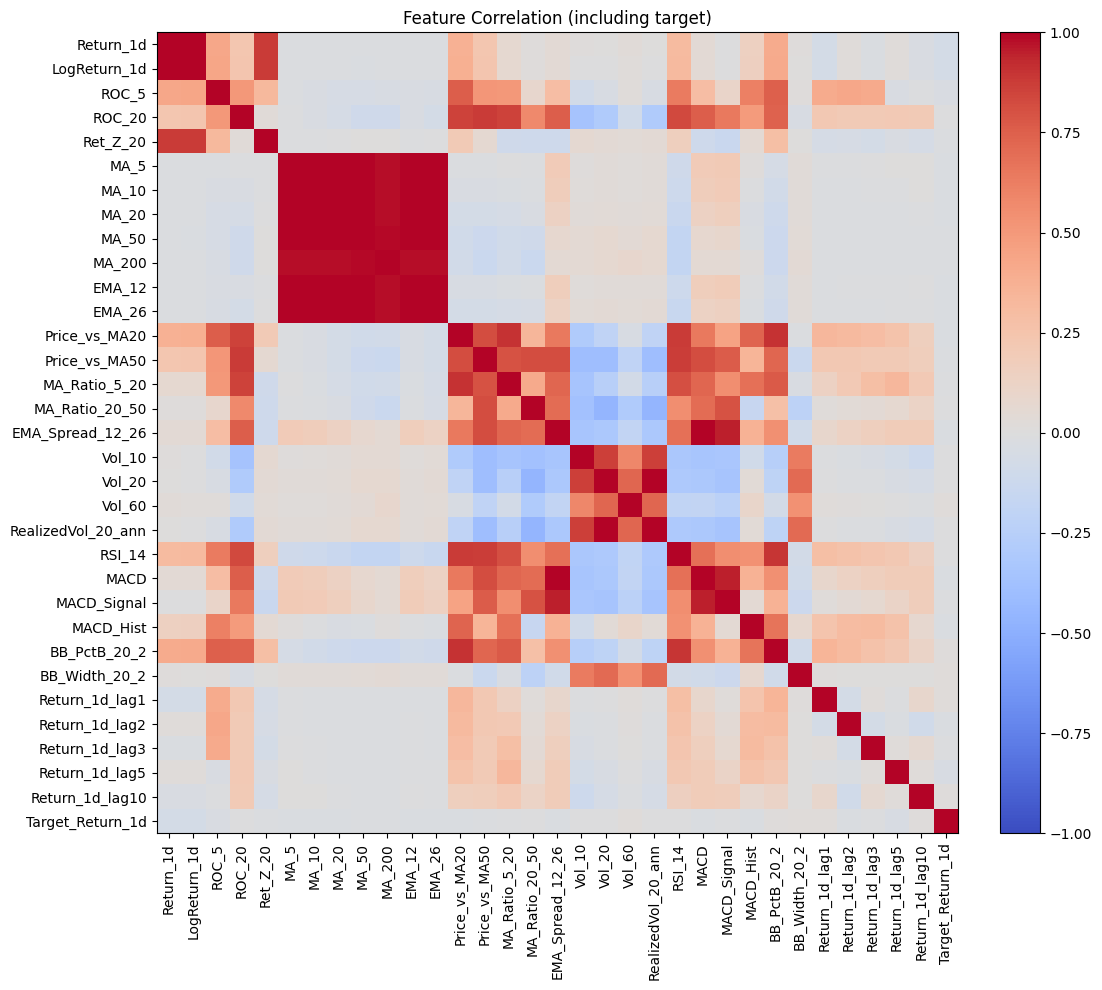

In [111]:
# ---------- 9) CORRELATIONS (features + target) ----------
# Build a list of all model features you created in Block 8 (no leakage features!)
features = [
    # returns & momentum
    "Return_1d","LogReturn_1d","ROC_5","ROC_20","Ret_Z_20",
    # trend / moving averages
    "MA_5","MA_10","MA_20","MA_50","MA_200","EMA_12","EMA_26",
    "Price_vs_MA20","Price_vs_MA50","MA_Ratio_5_20","MA_Ratio_20_50","EMA_Spread_12_26",
    # volatility
    "Vol_10","Vol_20","Vol_60","RealizedVol_20_ann",
    # indicators
    "RSI_14","MACD","MACD_Signal","MACD_Hist","BB_PctB_20_2","BB_Width_20_2",
    # lags (strictly past info)
    "Return_1d_lag1","Return_1d_lag2","Return_1d_lag3","Return_1d_lag5","Return_1d_lag10",
]

# Correlation matrix including target
corr = df_feat[features + [TARGET]].corr()

# Heatmap using matplotlib (no seaborn dependency)
plt.figure(figsize=(12, 10))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Feature Correlation (including target)")
plt.tight_layout()
plt.show()


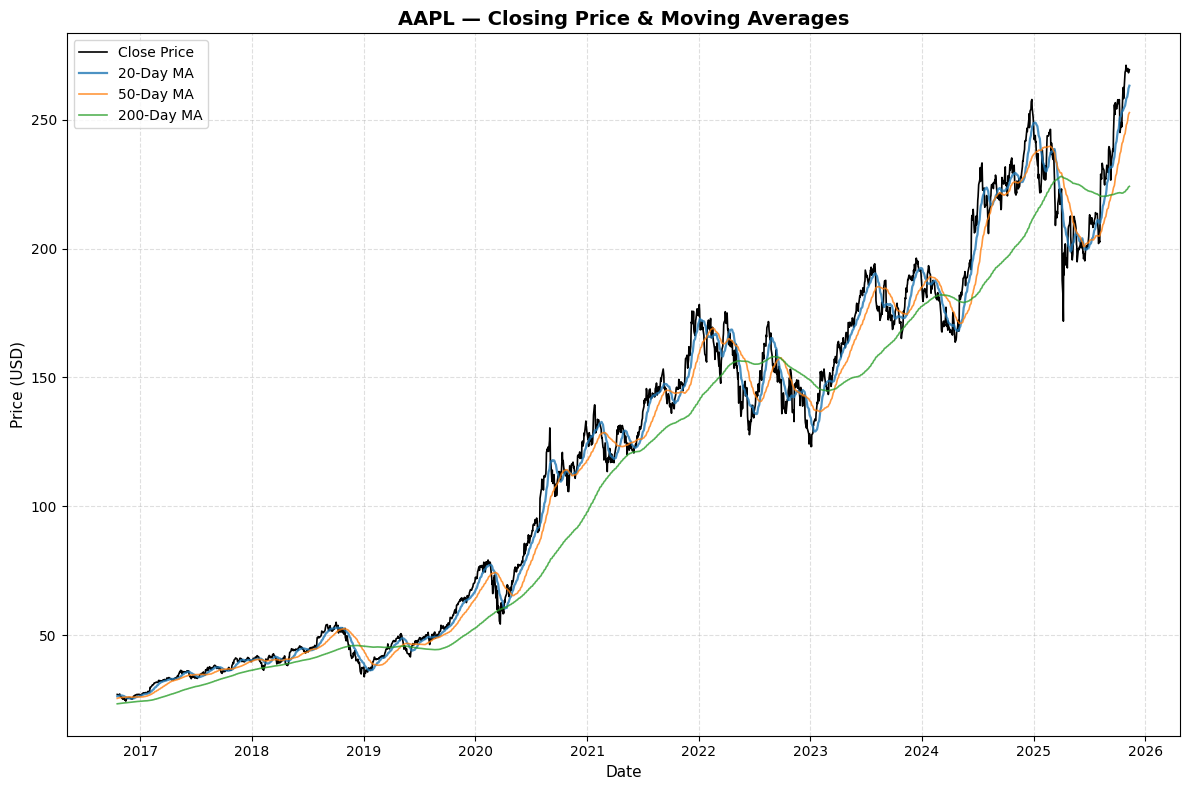

In [112]:
# ---------- Visualization: Closing Price with Moving Averages ----------
plt.figure(figsize=(12, 8))

# --- Plot Close and key MAs ---
plt.plot(df_feat.index, df_feat["Close"], label="Close Price", linewidth=1.2, color="black")
plt.plot(df_feat.index, df_feat["MA_20"], label="20-Day MA", linewidth=1.6, alpha=0.8)
plt.plot(df_feat.index, df_feat["MA_50"], label="50-Day MA", linewidth=1.2, alpha=0.8)
plt.plot(df_feat.index, df_feat["MA_200"],label="200-Day MA",linewidth=1.2, alpha=0.8)

# --- Styling ---
plt.title(f"{symbol} — Closing Price & Moving Averages", fontsize=14, weight="bold")
plt.xlabel("Date", fontsize=11)
plt.ylabel("Price (USD)", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()


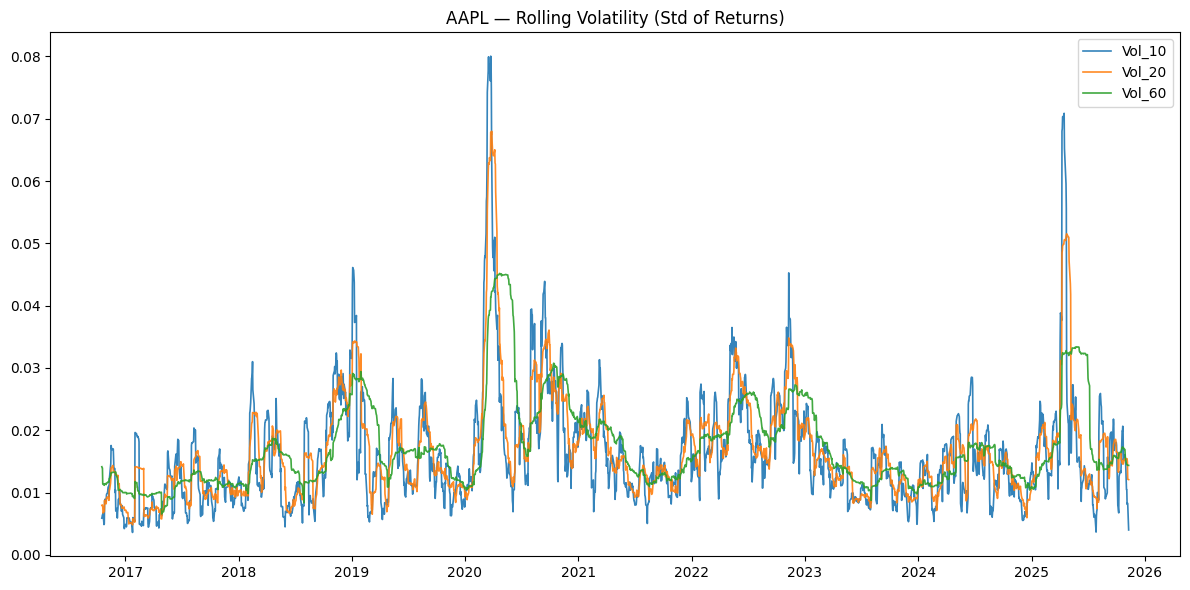

In [113]:
plt.figure(figsize=(12,6))
plt.plot(df_feat["Vol_10"], label="Vol_10", alpha=0.9, linewidth=1.2)
plt.plot(df_feat["Vol_20"], label="Vol_20", alpha=0.9, linewidth=1.2)
plt.plot(df_feat["Vol_60"], label="Vol_60", alpha=0.9, linewidth=1.2)
plt.title(f"{symbol} — Rolling Volatility (Std of Returns)")
plt.legend(); plt.tight_layout(); plt.show()

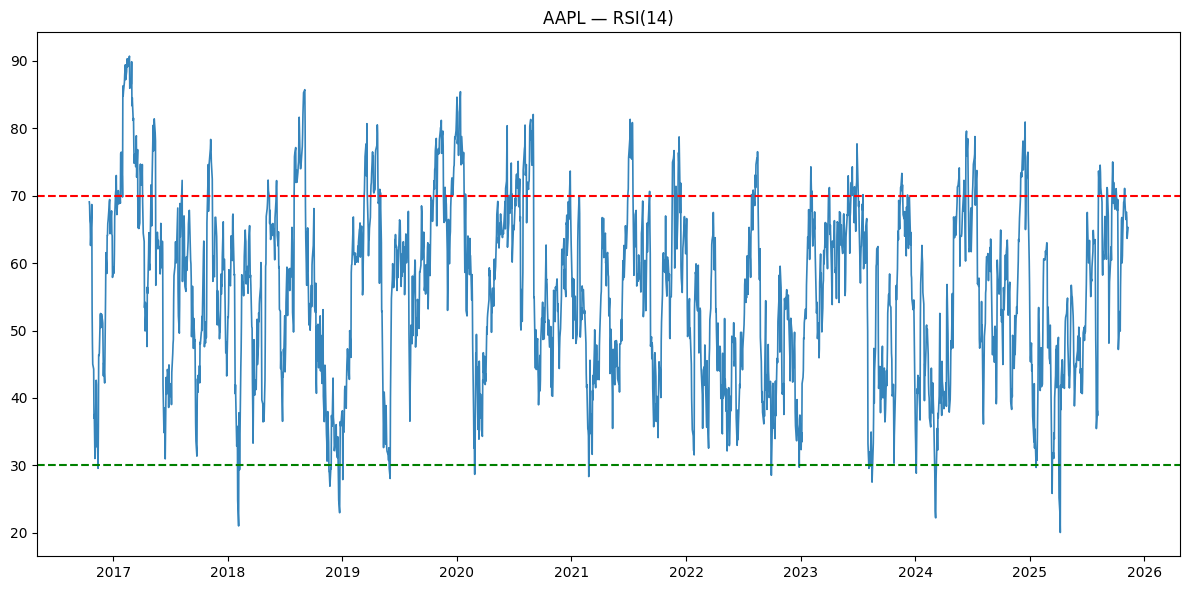

In [114]:
plt.figure(figsize=(12,6))
plt.plot(df_feat["RSI_14"], alpha=0.9, linewidth=1.2)
plt.axhline(70, color="r", linestyle="--", linewidth=1.5)
plt.axhline(30, color="g", linestyle="--", linewidth=1.5)
plt.title(f"{symbol} — RSI(14)")
plt.tight_layout(); plt.show()

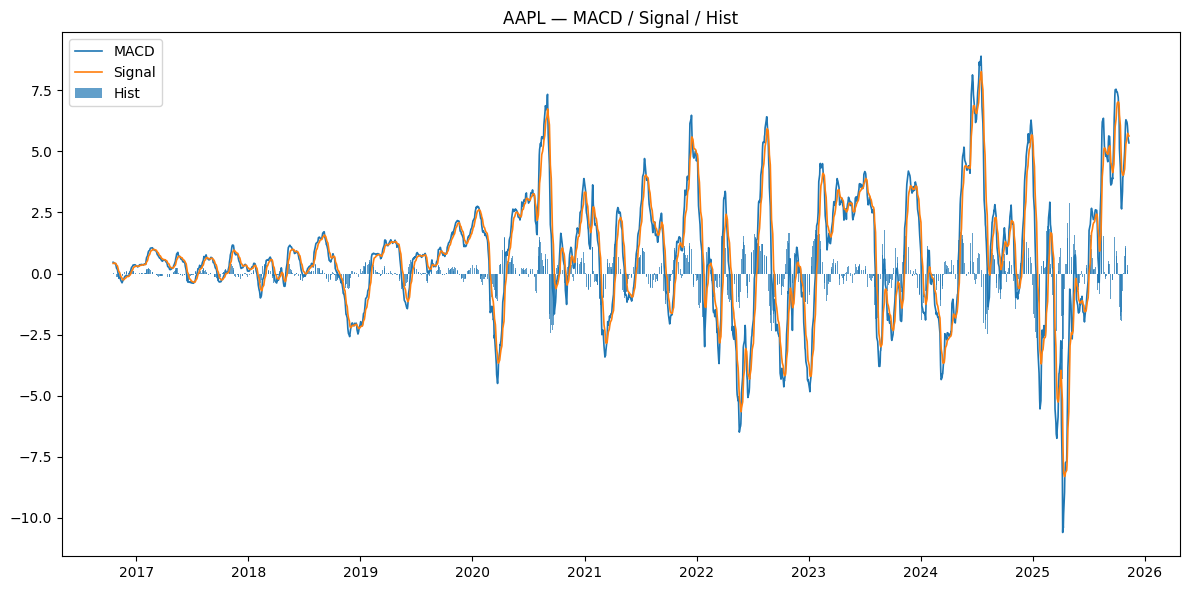

In [115]:
plt.figure(figsize=(12,6))
plt.plot(df_feat["MACD"], label="MACD", linewidth=1.2)
plt.plot(df_feat["MACD_Signal"], label="Signal", linewidth=1.2)
plt.bar(df_feat.index, df_feat["MACD_Hist"], label="Hist", alpha=0.7, width=1.5)
plt.title(f"{symbol} — MACD / Signal / Hist")
plt.legend(); plt.tight_layout(); plt.show()

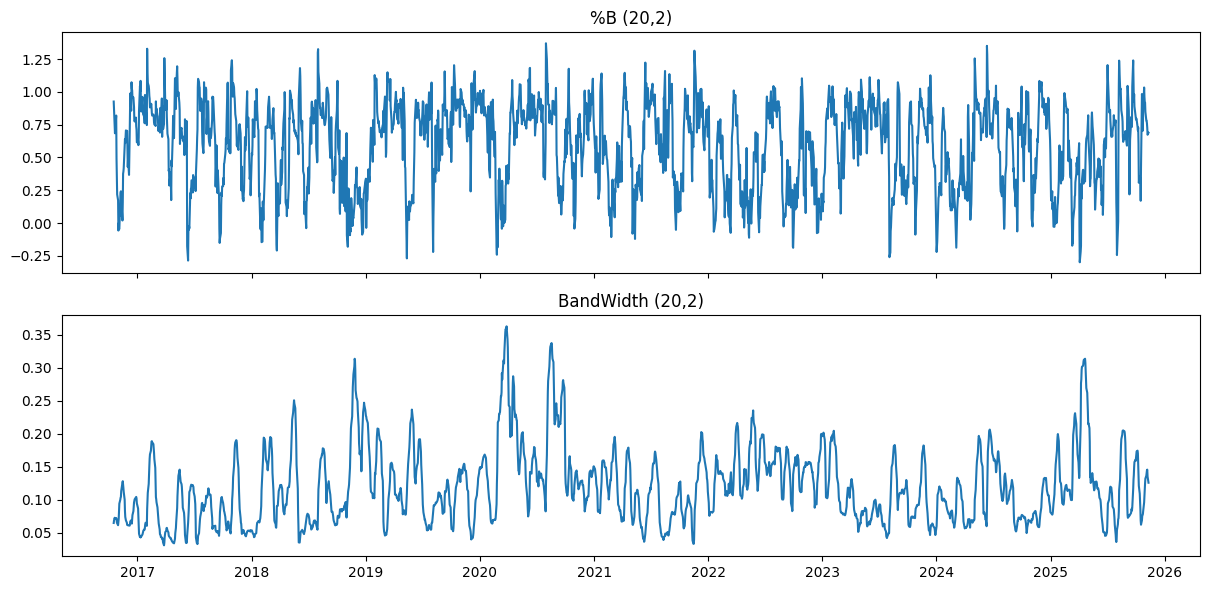

In [116]:
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
ax[0].plot(df_feat["BB_PctB_20_2"]); ax[0].set_title("%B (20,2)")
ax[1].plot(df_feat["BB_Width_20_2"]); ax[1].set_title("BandWidth (20,2)")
plt.tight_layout(); plt.show()

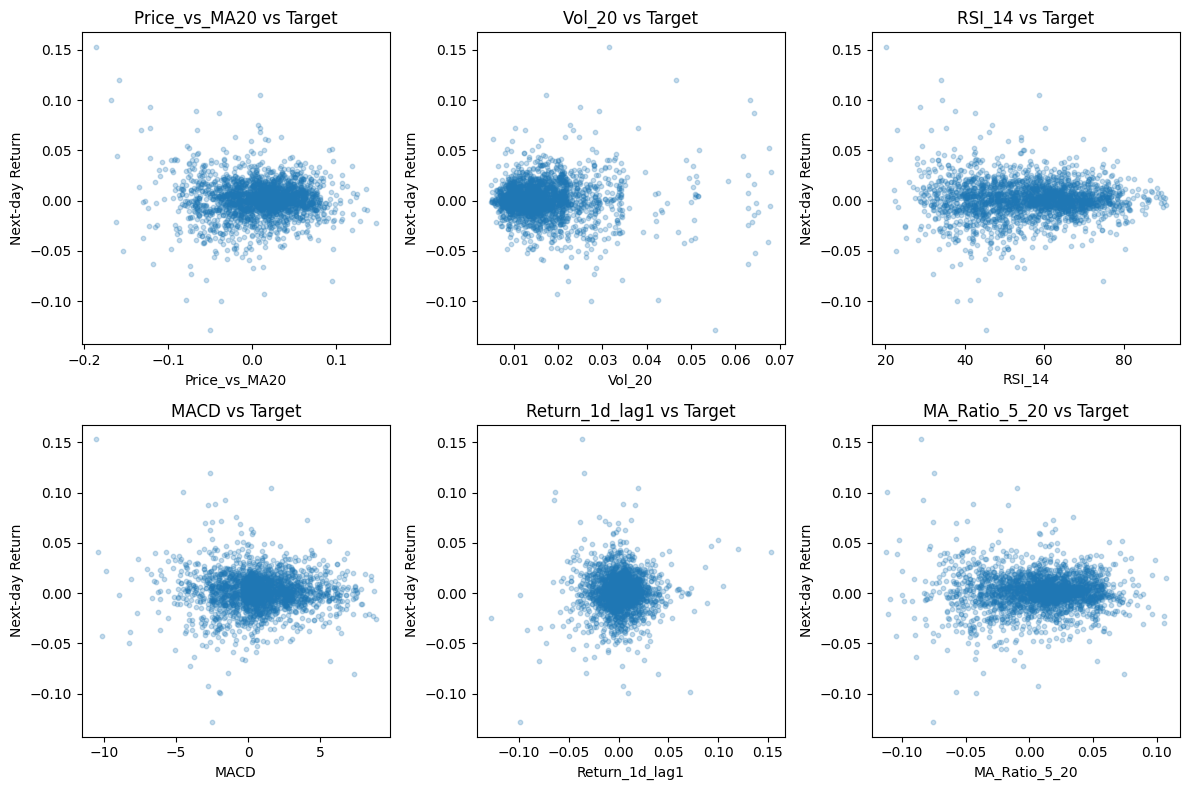

In [117]:
top_feats = ["Price_vs_MA20","Vol_20","RSI_14","MACD","Return_1d_lag1","MA_Ratio_5_20"]
plt.figure(figsize=(12,8))
for i, col in enumerate(top_feats, 1):
    plt.subplot(2, 3, i)
    plt.scatter(df_feat[col], df_feat[TARGET], alpha=0.25, s=10)
    plt.xlabel(col); plt.ylabel("Next-day Return"); plt.title(f"{col} vs Target")
plt.tight_layout(); plt.show()

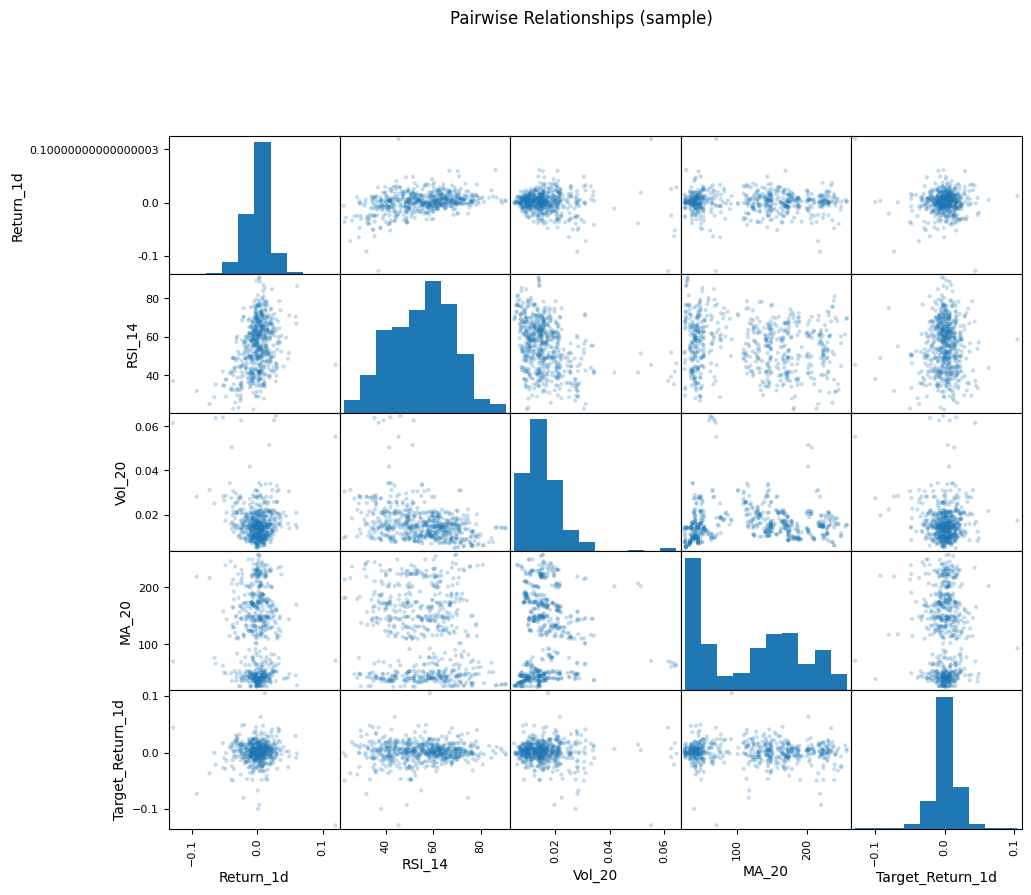

In [118]:
subset_cols = ["Return_1d","RSI_14","Vol_20","MA_20",TARGET]
subset = df_feat[subset_cols].sample(min(600, len(df_feat)), random_state=42)
pd.plotting.scatter_matrix(subset, figsize=(11,9), alpha=0.25, diagonal="hist")
plt.suptitle("Pairwise Relationships (sample)", y=1.02)
plt.show()

In [119]:
# ---------- 10) TRAIN / TEST SPLIT (TIME-BASED, NO SHUFFLE) ----------
X = df_feat[features]
y = df_feat[TARGET]

# choose your split date above; ensure it's within the index range
train_mask = X.index < pd.to_datetime(test_start_date)
X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[~train_mask], y[~train_mask]

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Train window:", X_train.index.min().date(), "→", X_train.index.max().date())
print("Test  window:", X_test.index.min().date(),  "→", X_test.index.max().date())


Train shape: (1813, 32) | Test shape: (467, 32)
Train window: 2016-10-17 → 2023-12-29
Test  window: 2024-01-02 → 2025-11-10


In [120]:
# ---------- 11) BASELINES ----------
# Use NumPy for RMSE calculation
def rmse(y_true, y_pred):
    """Root Mean Squared Error using NumPy."""
    return np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred)) ** 2))

# Baseline 1: persistence — predict tomorrow's return = today's return
baseline_pred = X_test["Return_1d"].values
baseline_rmse = rmse(y_test, baseline_pred)

# Baseline 2: simple mean of last few returns (lag1–3)
baseline_ma = X_test[["Return_1d_lag1","Return_1d_lag2","Return_1d_lag3"]].mean(axis=1).values
baseline_ma_rmse = rmse(y_test, baseline_ma)

print(f"Baseline (persistence) RMSE : {baseline_rmse:.6f}")
print(f"Baseline (lag1-3 mean) RMSE : {baseline_ma_rmse:.6f}")


Baseline (persistence) RMSE : 0.024966
Baseline (lag1-3 mean) RMSE : 0.021559


In [121]:
# ---------- 12) LINEAR REGRESSION ----------
lin = LinearRegression()
lin.fit(X_train, y_train)

lin_pred = lin.predict(X_test)
lin_rmse = rmse(y_test, lin_pred)
lin_r2   = r2_score(y_test, lin_pred)

print(f"Linear Regression — RMSE: {lin_rmse:.6f} | R²: {lin_r2:.4f}")


Linear Regression — RMSE: 0.018257 | R²: -0.0243


In [127]:
# ---------- 13) RANDOM FOREST + RANDOMIZED SEARCH (SMALL) ----------
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

tscv = TimeSeriesSplit(n_splits=3)  # fewer splits to speed up

rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)

param_dist = {
    "n_estimators": randint(150, 401),     # 150–400
    "max_depth": [None, 6, 10, 14],
    "min_samples_leaf": randint(1, 5),     # 1–4
    "max_features": ["sqrt", "log2", 0.7], # try smaller feature subsampling
}

rsearch = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=12,              # small budget
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=SEED,
    verbose=0
)
rsearch.fit(X_train, y_train)

best_rf = rsearch.best_estimator_
print("Best RF params:", rsearch.best_params_)

rf_pred = best_rf.predict(X_test)
rf_rmse = rmse(y_test, rf_pred)
rf_r2   = r2_score(y_test, rf_pred)
print(f"Random Forest — RMSE: {rf_rmse:.6f} | R²: {rf_r2:.4f}")


Best RF params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 253}
Random Forest — RMSE: 0.018721 | R²: -0.0771


In [128]:
# ---------- 14) METRICS SUMMARY ----------
def directional_accuracy(y_true, y_pred):
    """Share of predictions with correct sign (direction)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(np.sign(y_true) == np.sign(y_pred)))

def mape_safe(y_true, y_pred, eps=1e-8):
    """Stable MAPE for small or zero returns."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))))

metrics_test = {
    "baseline_persistence_rmse": float(baseline_rmse),
    "baseline_lagmean_rmse": float(baseline_ma_rmse),
    "linear_rmse": float(lin_rmse),
    "linear_r2": float(lin_r2),
    "rf_rmse": float(rf_rmse),
    "rf_r2": float(rf_r2),
    "linear_dir_acc": directional_accuracy(y_test, lin_pred),
    "rf_dir_acc": directional_accuracy(y_test, rf_pred),
    "linear_mape": mape_safe(y_test.values, lin_pred),
    "rf_mape": mape_safe(y_test.values, rf_pred),
}
metrics_test


{'baseline_persistence_rmse': 0.024965963327693318,
 'baseline_lagmean_rmse': 0.02155943600516819,
 'linear_rmse': 0.01825699463826946,
 'linear_r2': -0.024348490178216498,
 'rf_rmse': 0.01872080157560834,
 'rf_r2': -0.07705538374758936,
 'linear_dir_acc': 0.46466809421841543,
 'rf_dir_acc': 0.47109207708779444,
 'linear_mape': 422.2400572855683,
 'rf_mape': 1439.0872128356095}

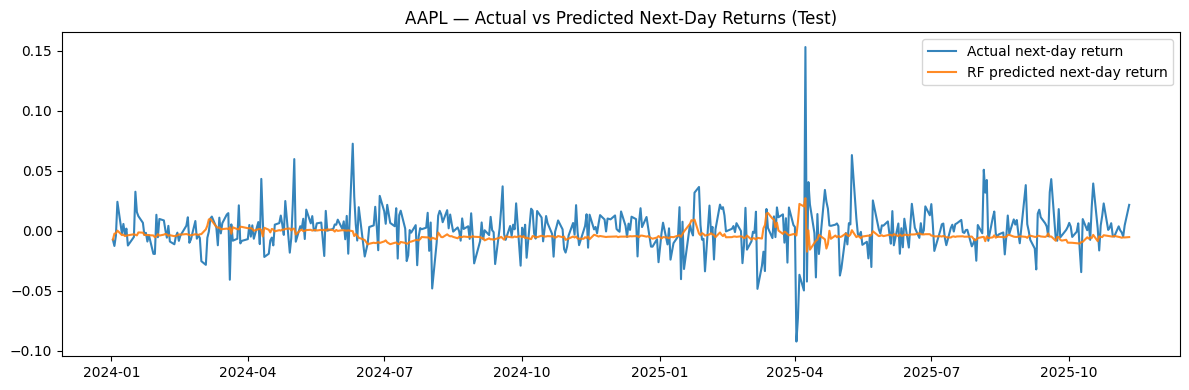

In [ ]:
# ---------- 15) PLOT: ACTUAL vs PREDICTED RETURNS ----------
plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label="Actual next-day return", alpha=0.9)
plt.plot(y_test.index, rf_pred,        label="RF predicted next-day return", alpha=0.9)
plt.title(f"{symbol} — Actual vs Predicted Next-Day Returns (Test)")
plt.legend()
plt.tight_layout()
plt.show()

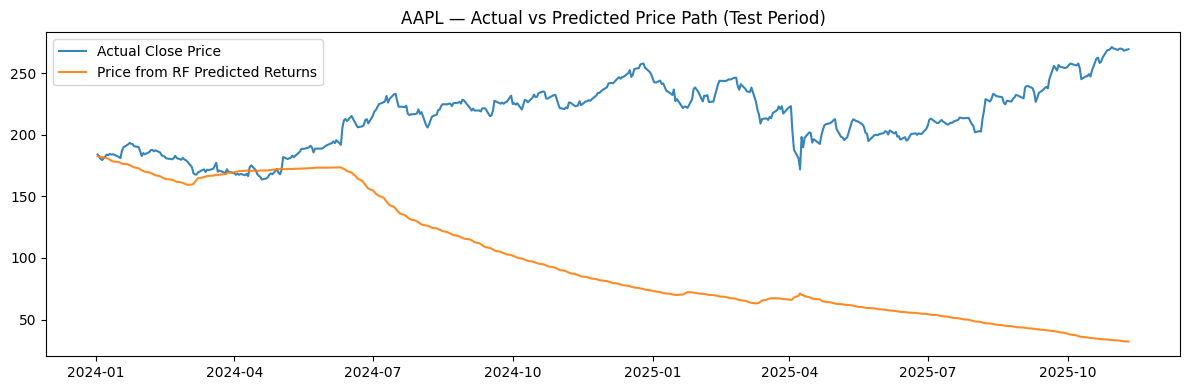

In [130]:
# ---------- 16) RETURNS → PRICE PATH (Close) ----------
# Rebuild a hypothetical price series from predicted returns for intuition
test_close = df.loc[y_test.index, "Close"].copy()

def apply_returns(p0, rets):
    """Cumulative price reconstruction from predicted returns."""
    path = [p0]
    for r in rets:
        path.append(path[-1] * (1 + r))
    return np.array(path[1:])

rf_price_path = apply_returns(test_close.iloc[0], rf_pred)

plt.figure(figsize=(12,4))
plt.plot(test_close.index, test_close.values, label="Actual Close Price", alpha=0.9)
plt.plot(test_close.index, rf_price_path,      label="Price from RF Predicted Returns", alpha=0.9)
plt.title(f"{symbol} — Actual vs Predicted Price Path (Test Period)")
plt.legend()
plt.tight_layout()
plt.show()


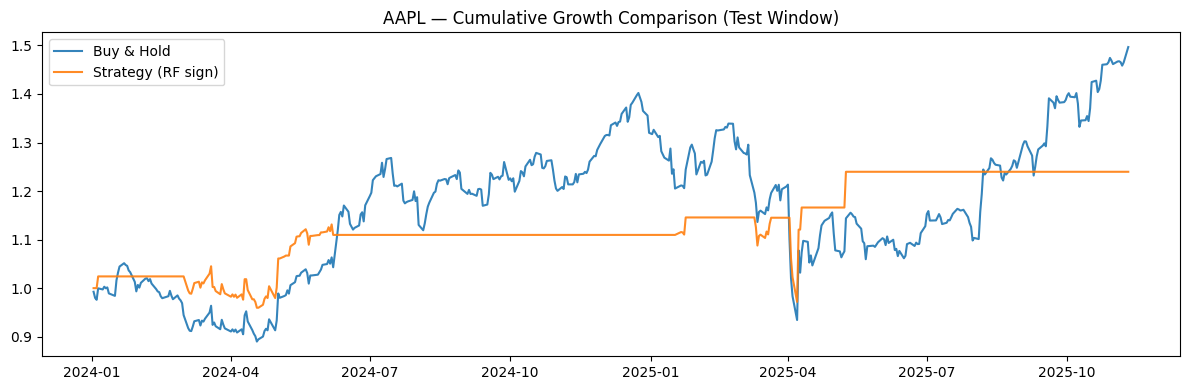

Directional accuracy (RF): 47.11%


In [131]:
# ---------- 17) TOY STRATEGY BACKTEST ----------
# Long if predicted next-day return > 0; flat otherwise (no shorting/costs)
position = (rf_pred > 0).astype(int)
strategy_returns = position * y_test.values
bh_returns = y_test.values  # Buy & Hold baseline

cum_bh = np.cumprod(1 + bh_returns)
cum_strategy = np.cumprod(1 + strategy_returns)

plt.figure(figsize=(12,4))
plt.plot(y_test.index, cum_bh, label="Buy & Hold", alpha=0.9)
plt.plot(y_test.index, cum_strategy, label="Strategy (RF sign)", alpha=0.9)
plt.title(f"{symbol} — Cumulative Growth Comparison (Test Window)")
plt.legend()
plt.tight_layout()
plt.show()

print("Directional accuracy (RF):", f"{metrics_test['rf_dir_acc']:.2%}")


Return_1d_lag1        1.141840e-02
Return_1d_lag5        3.533225e-03
Return_1d_lag3        3.049997e-03
MA_50                 2.177419e-03
Vol_20                1.373093e-03
Vol_60                1.303205e-03
RealizedVol_20_ann    7.576685e-04
Ret_Z_20              5.618532e-04
ROC_20                5.411846e-04
BB_PctB_20_2          5.391518e-04
MACD_Hist             5.366807e-04
BB_Width_20_2         2.279231e-04
MA_10                 2.054766e-04
EMA_12                7.425985e-05
MA_200               -1.554312e-16
dtype: float64

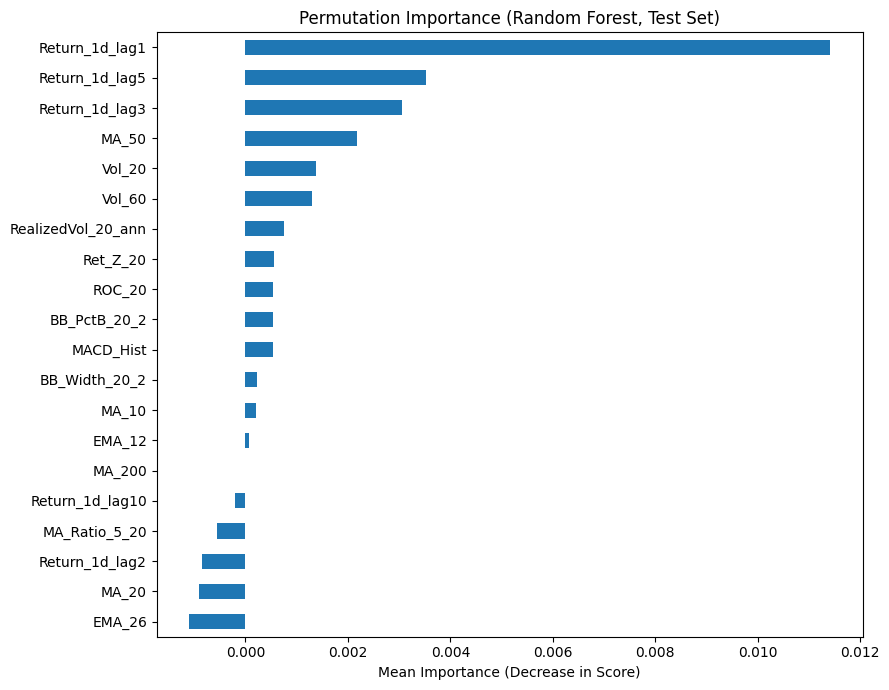

In [132]:
# ---------- 18) FEATURE IMPORTANCE (PERMUTATION) ----------
# Permutation importance = performance drop when a feature is randomly shuffled
perm = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=SEED, n_jobs=-1)
imp = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)

display(imp.head(15))

plt.figure(figsize=(9,7))
imp.head(20).sort_values().plot(kind="barh")
plt.title("Permutation Importance (Random Forest, Test Set)")
plt.xlabel("Mean Importance (Decrease in Score)")
plt.tight_layout()
plt.show()


In [133]:
# ---------- 19) WALK-FORWARD VALIDATION (OPTIONAL) ----------
def walk_forward_rmse(X, y, splits=5):
    """Expanding-window validation to assess temporal robustness."""
    tscv = TimeSeriesSplit(n_splits=splits)
    rmses = []
    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
        model = RandomForestRegressor(
            n_estimators=300, min_samples_leaf=2, random_state=SEED, n_jobs=-1
        )
        model.fit(X_tr, y_tr)
        pred_va = model.predict(X_va)
        fold_rmse = np.sqrt(np.mean((y_va - pred_va) ** 2))
        rmses.append(fold_rmse)
        print(f"Fold {fold}: RMSE = {fold_rmse:.6f}")
    return rmses

wf_rmses = walk_forward_rmse(X_train, y_train, splits=5)
print("Walk-forward average RMSE:", np.mean(wf_rmses))


Fold 1: RMSE = 0.020143
Fold 2: RMSE = 0.035519
Fold 3: RMSE = 0.037378
Fold 4: RMSE = 0.019338
Fold 5: RMSE = 0.017824
Walk-forward average RMSE: 0.026040325060803653
